In [2]:
from monai import transforms as mtf
import monai.transforms.spatial.functional as mtsf
import torch
from contextlib import nullcontext
import joblib
from typing import Any
import numpy as np, os, shutil
from tqdm.notebook import tqdm
from glio import transforms as gtf
from glio.torch_tools import area_around, center_of_mass, to_binary
from glio.datasets.BRaTS2024 import Preprocessor
from glio.data import DSToTarget
from glio.loaders import niiread, niireadtensor
from glio.transforms import norm_to01, z_normalize, z_normalize_channels
from torchvision.transforms import v2
from glio.jupyter_tools import show_slices, show_slices_arr
from glio.visualize import Visualizer, vis_imshow, vis_imshow_grid
from glio.plot import *
from glio.python_tools import listdir_fullpaths, find_file_containing, SliceContainer, get0, get1
from glio.progress_bar import PBar
from glio.mri.preprocess_datasets import preprocess_brats2024goat

# Оригинал

torch.Size([240, 240, 155]) = 


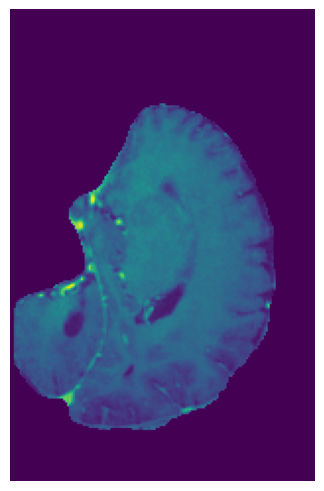

In [3]:
img = niireadtensor(r"E:\dataset\BRaTS2024-GoAT\ISBI2024-BraTS-GoAT-TrainingData\BraTS-GoAT-00000\BraTS-GoAT-00000-t1c.nii.gz")
print(f"{img.shape} = ")
qimshow(img[100])

# Объект без фона

1.1507472494158912e-16 0.9999998423351912
(4, 135, 169, 139) (135, 169, 139)


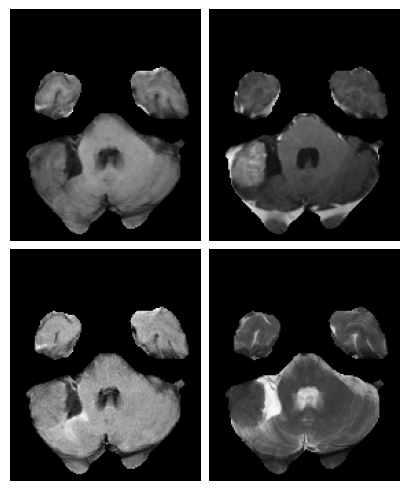

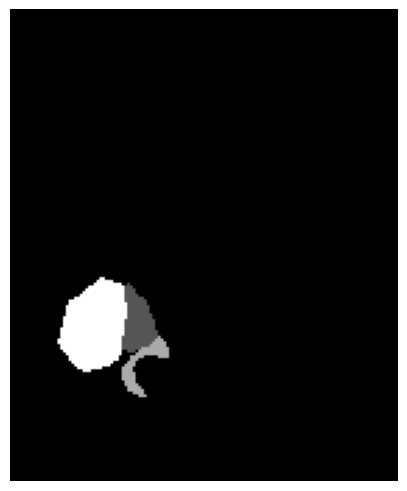

In [4]:
arr, seg = preprocess_brats2024goat(r'E:\dataset\BRaTS2024-GoAT\ISBI2024-BraTS-GoAT-TrainingData\BraTS-GoAT-00000')
print(arr.mean(), arr.std())
print(arr.shape, seg.shape)
qimshow_grid(arr[:, 30])
qimshow(seg[30])

# Результаты

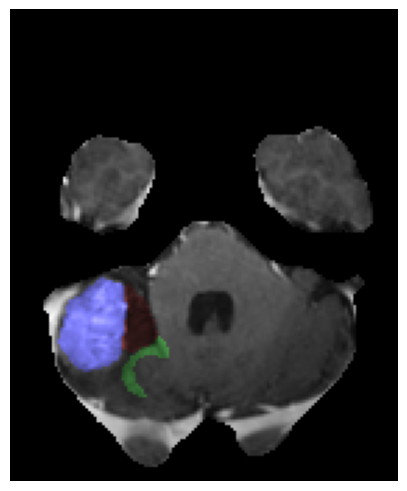

In [5]:
from glio.specific.vkr import visualize_3_segm_classes
qimshow(visualize_3_segm_classes(torch.from_numpy(arr)[1][30], torch.from_numpy(seg.astype(np.int32))[30], magn=2))

# Ориентация изображения

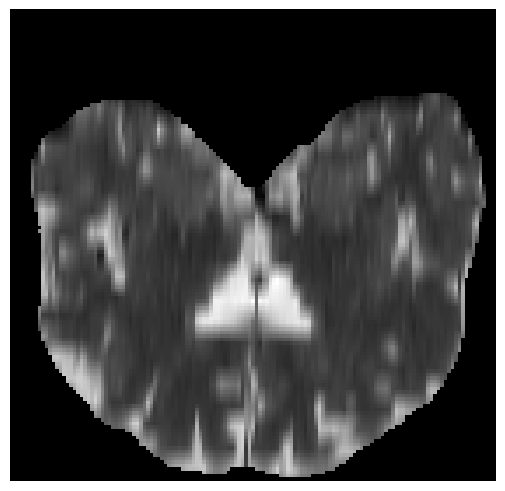

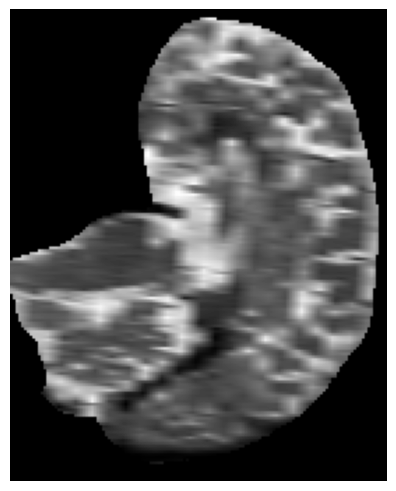

In [6]:
qimshow(arr[3].swapaxes(0,1)[70])
qimshow(arr[3].swapaxes(0,2)[70])

# Предсохранение

ZipStore со следующей стуктурой:

- Каждая группа по названию обследования включает массивы: `side`, `side_seg`, `side_centers`, `top`, ..., `front`, ...

- Структура `side`/`front`/`top`: Массив размером (2, 4, 140*, 180*, 140*)
    1. [nohist, hist] 
    2. [t1c, t1n, t2f, t2w] 
    3. [*срезы] 
    4. [*h] 
    5. [*w]



In [7]:
BRATS_PATH = r"E:\dataset\BRaTS2024-GoAT\ISBI2024-BraTS-GoAT-TrainingData"
SIZE = 96

dstrain = []
#dstrain_nohist = []
dstest = []
#dstest_nohist = []

for obs_i, obs in enumerate(tqdm(listdir_fullpaths(BRATS_PATH))):

    images, segmentations = preprocess_brats2024goat(obs)
    images = torch.from_numpy(images)
    segmentations = torch.from_numpy(segmentations.astype(np.int32))

    # preprocess
    center = center_of_mass(to_binary(segmentations, 0))
    images = area_around(images, center, (SIZE, SIZE, SIZE)).to(torch.float16).clone()
    segmentations = area_around(segmentations, center, (SIZE, SIZE, SIZE)).to(torch.uint8).clone()
    # images = images.to(torch.float16).clone()
    # segmentations = segmentations.to(torch.uint8).clone()

    samples = []
    # save side
    slices = []
    #slices_nohist = []
    for i, sl in enumerate(to_binary(segmentations, 0)):
        if sl.sum() > 0:
            # save center and seg
            slices.append((SliceContainer(images, (slice(None), i)), SliceContainer(segmentations, i)))
            #slices_nohist.append((SliceContainer(images_nohist, (slice(None), i)), SliceContainer(segmentations, i)))
    samples.append(slices)
    #samples_nohist.append(slices_nohist)

    # save front
    slices = []
    #slices_nohist = []
    for i, sl in enumerate(to_binary(segmentations.swapaxes(0,1), 0)):
        if sl.sum() > 0:
            # save center and seg
            slices.append((SliceContainer(images, (slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), i))))
            #slices_nohist.append((SliceContainer(images_nohist, (slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), i))))
    samples.append(slices)
    #samples_nohist.append(slices_nohist)

    # save top
    slices = []
    #slices_nohist = []
    for i, sl in enumerate(to_binary(segmentations.swapaxes(0,2), 0)):
        if sl.sum() > 0:
            # save center and seg
            slices.append((SliceContainer(images, (slice(None),slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), slice(None), i))))
            #slices_nohist.append((SliceContainer(images_nohist, (slice(None),slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), slice(None), i))))
    samples.append(slices)
    #samples_nohist.append(slices_nohist)


    if obs_i < 2000:
        dstrain.extend(samples)
        #dstrain_nohist.extend(samples_nohist)
    else:
        dstest.extend(samples)
        #dstest_nohist.extend(samples_nohist)

  0%|          | 0/2251 [00:00<?, ?it/s]

In [8]:
joblib.dump(dstrain, r'E:\dataset\BRaTS2024-GoAT\brats2024-96 v2 train.joblib', compress=3)
joblib.dump(dstest, r'E:\dataset\BRaTS2024-GoAT\brats2024-96 v2 test.joblib', compress=3)

['E:\\dataset\\BRaTS2024-GoAT\\brats2024-96 v2 test.joblib']

# Тест

In [9]:
from glio.datasets import BRaTS2024_preloaded
ds = BRaTS2024_preloaded.get_ds_around(r'E:\dataset\BRaTS2024-GoAT\brats2024-96 v2 test.joblib')

In [12]:
show_slices_arr(ds[1241][0])

overflow encountered in reduce


interactive(children=(Checkbox(value=False, description='color'), Text(value='0 1 2 3', description='permute')…

<function glio.jupyter_tools.show_slices_arr.<locals>.f(color, permute: str, **kwargs)>